In [667]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
# include("../src/worker_fct.jl")
using LaTeXStrings
data_type = "cal";
set = "sim";
high_cut = 4;
dat_col = "#009AF9";
sim_col = "#E26F46";

In [ ]:
# Done
# 0:4 11:26 30:33

In [1365]:
ch = 35
ch_str = lpad(ch, 2, "0");

plots_path = "../plots/sim/" * ch_str * "-" * ctn[ch] * "/" *set * "/"
base_path  = joinpath("../../waveforms/sim/", "wf")
base_path_AE  = joinpath("../../waveforms/sim/", "calib_AE")

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)
slice_filepath = "../dicts/slices_sim/"
slice_lib = JSON.parsefile(slice_lib_filepath)

photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2103.5, 2614.5]; # keV

In [1366]:
if !ctb[ch]
    println("STOP here! This is a coax detector.")
else
    if !haskey(calib, ctn[ch])
        calib[ctn[ch]] = Dict()
        calib[ctn[ch]]["data"] = Dict()
        calib[ctn[ch]]["sim"] = Dict()
    end

    calib = JSON.parsefile(calib_filepath)
    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    slice_lib_filepath = "../dicts/slice_lib.json"
    slice_filepath = "../dicts/slices_sim/"
    slice_lib = JSON.parsefile(slice_lib_filepath)
end;

# A/E energy dependency

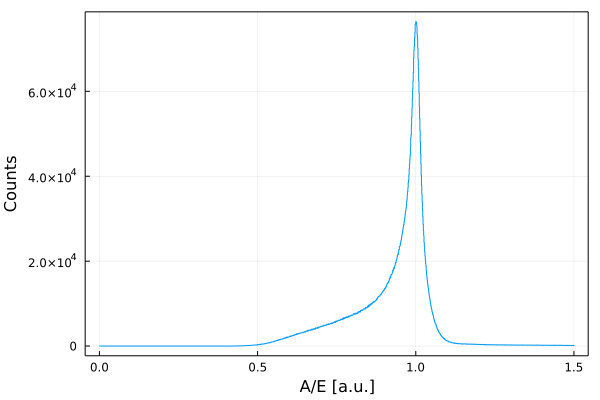

In [1367]:
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = isfile(AE_cal_filepath) ? JSON.parsefile(AE_cal_filepath) : Dict()
!haskey(AE_cal, ctn[ch]) ? AE_cal[ctn[ch]] = Dict() : ""
!haskey(AE_cal[ctn[ch]], set) ? AE_cal[ctn[ch]][set] = Dict() : ""
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
h = fit(Histogram, AoE, 0:0.0001:0.3)
AE_norm = h.edges[1][findfirst(x->x == maximum(h.weights), h.weights)]
AoE ./= AE_norm
h = fit(Histogram, AoE, 0:0.001:1.5)
calib[ctn[ch]][set]["AE_norm"] = AE_norm
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end
p = plot(h, st=:step, label="")
p = plot!(xlabel="A/E [a.u.]", ylabel="Counts", legend=false, framestyle=:box)
filename = joinpath(plots_path, "AoverE_all-events_norm.pdf")
savefig(p, filename)
display(p)

# Energy spectrum

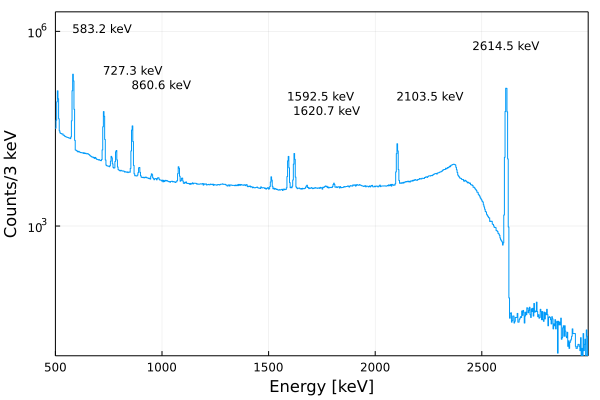

In [1368]:
E = data.E
h = fit(Histogram, E, 350:3:3000)
photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2105.5, 2614.5]; # keV
p = plot(h, st=:step, yscale=:log10, ylim=(1e1,2e6), xlim=(500,maximum(h.edges[1])))
p = annotate!(583.2, 1.1e6, text("583.2 keV", :black, :left, 8))
p = annotate!(727.3, 2.5e5, text("727.3 keV", :black, :left, 8))
p = annotate!(860.6, 1.5e5, text("860.6 keV", :black, :left, 8))
p = annotate!(1592.5, 1e5, text("1592.5 keV", :black, :left, 8))
p = annotate!(1620.7, 6e4, text("1620.7 keV", :black, :left, 8))
p = annotate!(2103.5, 1e5, text("2103.5 keV", :black, :left, 8))
p = annotate!(2614.5, 6e5, text("2614.5 keV", :black, 8))
p = plot!(legend=false, framestyle=:box, xlabel="Energy [keV]", ylabel="Counts/3 keV")
filename = joinpath(plots_path, "energy_spectrum.pdf")
savefig(p, filename)
p

# A/E Fit DEP

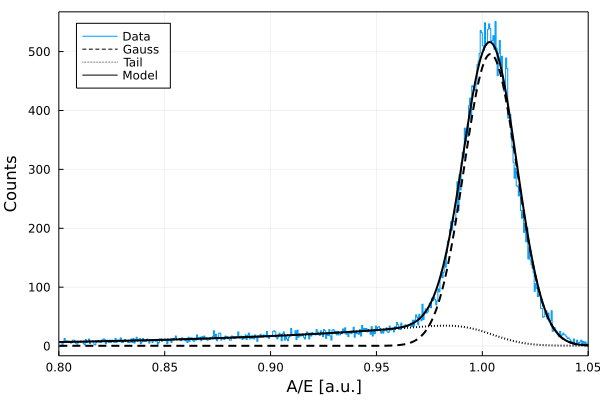

In [1369]:
E = deepcopy(data.E)
A = deepcopy(data.A)

E_min = calib[ctn[ch]][set]["fits"]["peaks_first_cal"]["1592.5"][1]["μ"] - 3*calib[ctn[ch]][set]["fits"]["peaks_first_cal"]["1592.5"][1]["σ"]
E_max = calib[ctn[ch]][set]["fits"]["peaks_first_cal"]["1592.5"][1]["μ"] + 3*calib[ctn[ch]][set]["fits"]["peaks_first_cal"]["1592.5"][1]["σ"]
index = findall(x->x > E_min && x < E_max, E)

AoE = A[index] ./ E[index]
AoE ./= calib[ctn[ch]][set]["AE_norm"]
rng_start = 0.9
rng_end = 1.05
rng_step = 0.0005
h = fit(Histogram, AoE, rng_start-0.1:rng_step:rng_end+0.1);
prior = NamedTupleDist(
    n = sum(h.weights)/10..sum(h.weights),
    σ = 1e-3..0.02,
    μ = 0.99..1.01,
    bkg_l = 0.1..800.0,
    bkg_r = 0.1..800.0,
    c = 1e2..1e4,
    d = 0..500.0,
    β = 0.01..1.0
)
samples = try bat_fit(h, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
catch
    IJulia.clear_output(true)
    try bat_fit(h, peak, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false);
    catch
        IJulia.clear_output(true)
        bat_fit(h, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
    end
end
    

IJulia.clear_output(true)
par, err = mode(samples), std(samples)

x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
y_tail = peak(x_fit, par_tail)
y_tail ./= sum(y_tail)
y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
y_tail .*= sum(h.weights)

par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = 0, d = par.d, β = par.β)
y_gauss = peak(x_fit, par_gauss)
y_gauss ./= sum(y_gauss)
y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
y_gauss .*= sum(h.weights)


p = plot(h, st=:step, label="Data");
p = plot!(x_fit, y_gauss, color=:black, style=:dash, lw=2, label="Gauss");
p = plot!(x_fit, y_tail, color=:black, style=:dot, lw=2, label="Tail");
p = plot!(x_fit, y_fit, lw=2, color=:black, label="Model");
p = plot!(xlabel="A/E [a.u.]", ylabel="Counts", xlim=(0.8, 1.05), framestyle=:box, legend=:topleft);
filename = joinpath(plots_path, "AoverE_DEP-peak.pdf");
savefig(p, filename);
display(p)
filename = joinpath(plots_path, "AoverE_DEP-peak.pdf");
savefig(p, filename);
AE_cal[ctn[ch]][set]["DEP_fit"] = [par, err]
open(AE_cal_filepath, "w") do f
    JSON.print(f, AE_cal, 4)
end

# A/E energy dependency

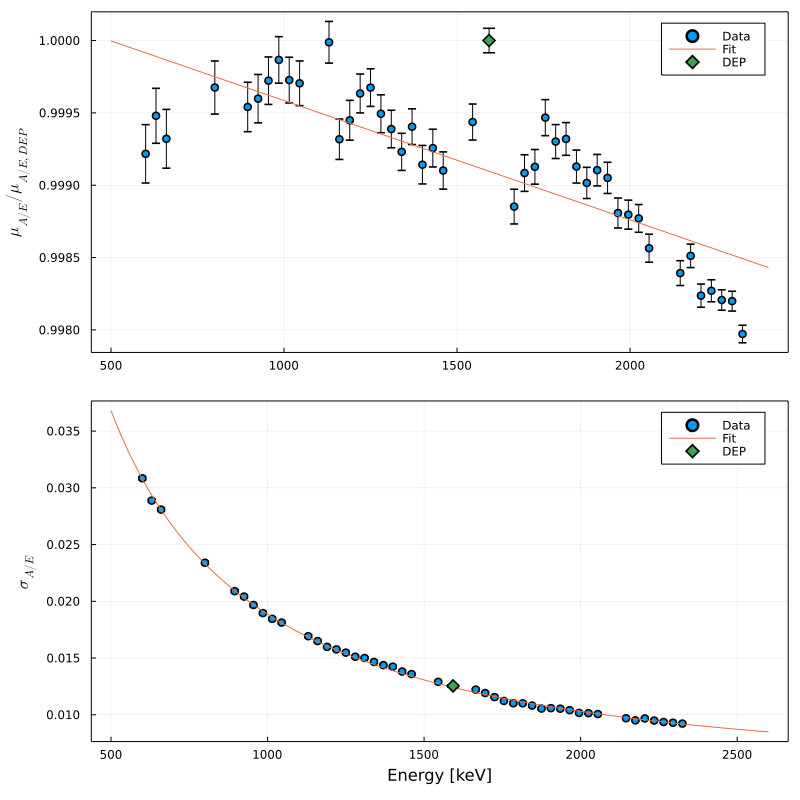

In [1370]:
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = isfile(AE_cal_filepath) ? JSON.parsefile(AE_cal_filepath) : Dict()
!haskey(AE_cal, ctn[ch]) ? AE_cal[ctn[ch]] = Dict() : ""
!haskey(AE_cal[ctn[ch]], set) ? AE_cal[ctn[ch]][set] = Dict() : "";

mu = Dict()
mu["slice"] = []
mu["pos"] = []
mu["err"] = []
for (k,v) in slice_lib[ctn[ch]][set]["AE_slices"]
    if haskey(v, "peak")
        push!(mu["slice"], parse(Float64, k))
        push!(mu["pos"], v["peak"][1]["μ"])
        push!(mu["err"], v["peak"][2]["μ"])
    end
end
x = mu["slice"]
p0 = [.0, 1.0]
f = curve_fit(linmodel, x, mu["pos"], p0)
x_fit = 500:10:2400
y_fit = linmodel(x_fit, f.param)
norm_factor = AE_cal[ctn[ch]][set]["DEP_fit"][1]["μ"]
p1 = scatter(mu["slice"], mu["pos"] ./ norm_factor, yerr=mu["err"], label="Data");
p1 = plot!(x_fit, y_fit ./ norm_factor, label="Fit");
p1 = scatter!([1592.5], [1], yerr=[AE_cal[ctn[ch]][set]["DEP_fit"][2]["μ"]], label="DEP", markershape = :diamond, markersize=6)
p1 = plot!(xlabel="Energy [keV]", ylabel=L"\mu_{A/E} / \mu_{A/E, DEP}", framestyle=:box);

AE_cal[ctn[ch]][set]["lin_x"]     = mu["slice"]
AE_cal[ctn[ch]][set]["lin_y"]     = mu["pos"]
AE_cal[ctn[ch]][set]["lin_y_err"] = mu["err"]
AE_cal[ctn[ch]][set]["lin_fit"]     = f.param
AE_cal[ctn[ch]][set]["DEP_norm"]    = norm_factor / linmodel(1592.5, f.param)
AE_cal[ctn[ch]][set]["lin_fit_err"] = LsqFit.standard_errors(f)


sig = Dict()
sig["slice"] = []
sig["pos"] = []
sig["err"] = []
for (k,v) in slice_lib[ctn[ch]][set]["AE_slices"]
    if haskey(v, "peak")
        push!(sig["slice"], parse(Float64, k))
        push!(sig["pos"], v["peak"][1]["σ"])
        push!(sig["err"], v["peak"][2]["σ"])
    end
end
x = sig["slice"]
p0 = [.01, 50.0]
f = curve_fit(hypmodel, x, sig["pos"], p0, lower=[1e-7,0.0])
x_fit = 500:10:2600
y_fit = hypmodel(x_fit, f.param)
p2 = scatter(sig["slice"], sig["pos"], yerr=sig["err"], label="Data");
p2 = plot!(x_fit, y_fit, label="Fit");
p2 = scatter!([1592.5], [AE_cal[ctn[ch]][set]["DEP_fit"][1]["σ"]], yerr=[AE_cal[ctn[ch]][set]["DEP_fit"][2]["μ"]], label="DEP", 
    markershape = :diamond, markersize=6)
p2 = plot!(xlabel="Energy [keV]", ylabel=L"\sigma_{A/E}", framestyle=:box);

AE_cal[ctn[ch]][set]["sig_x"]     = sig["slice"]
AE_cal[ctn[ch]][set]["sig_y"]     = sig["pos"]
AE_cal[ctn[ch]][set]["sig_y_err"] = sig["err"]
AE_cal[ctn[ch]][set]["sig_fit"]     = f.param
AE_cal[ctn[ch]][set]["sig_fit_err"] = LsqFit.standard_errors(f)
open(AE_cal_filepath, "w") do f
    JSON.print(f, AE_cal, 4)
end

filename = joinpath(plots_path, "AoverE_energy_dependency.pdf")

p = plot(p1, p2, layout=(2,1), size=(800,800), xlabel=["" "Energy [keV]"])
savefig(p, filename)
p

# A/E spectrum

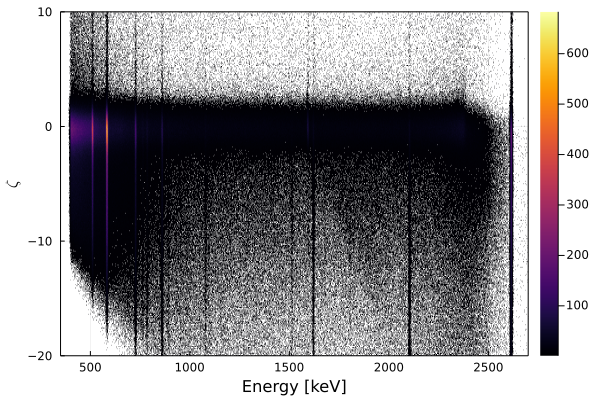

In [1371]:
AE_cal = JSON.parsefile(AE_cal_filepath)
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
AoE ./= calib[ctn[ch]][set]["AE_norm"]
AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
AoE .-= 1
AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

p = histogram2d(E, AoE, bins=(300:0.5:2800, -30:0.1:30))
# p = histogram2d(E, AoE, bins=(1570:0.25:1650, -30:0.1:30))
p = plot!(xlabel="Energy [keV]", ylabel=L"\zeta")
p = plot!(framestyle=:box, xlim=(350,2700), ylim=(-20,10))
# p = plot!(framestyle=:box, xlim=(1580,1640), ylim=(-30,30))
filename = joinpath(plots_path, "AoverE_classifier.pdf")
# filename = joinpath(plots_path, "AoverE_classifier.png")
savefig(p, filename)
p

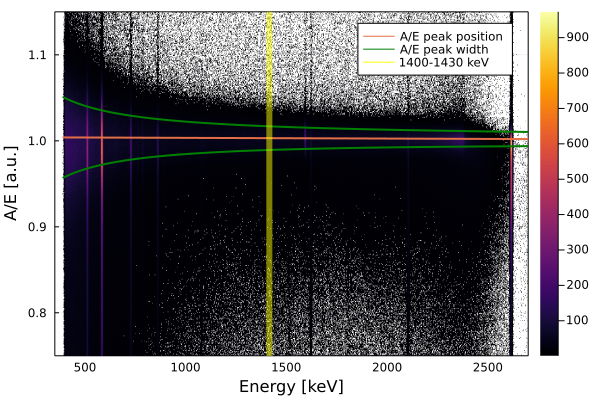

In [1372]:
AE_cal = JSON.parsefile(AE_cal_filepath)
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
AoE ./= calib[ctn[ch]][set]["AE_norm"]
p = histogram2d(E, AoE, bins=(300:2:2700, 0.4:0.001:1.25))
x_E = minimum(E):10:maximum(E)
peak_pos = linmodel(x_E, AE_cal[ctn[ch]][set]["lin_fit"])
p = plot!(x_E, peak_pos, label="A/E peak position", lw=2)
p = plot!(x_E, hypmodel(x_E, AE_cal[ctn[ch]][set]["sig_fit"]).+peak_pos, label="A/E peak width", color=:green, lw=2)
p = plot!(x_E, -hypmodel(x_E, AE_cal[ctn[ch]][set]["sig_fit"]).+peak_pos, label="", color=:green, lw=2)

p = plot!(xlabel="Energy [keV]", ylabel="A/E [a.u.]")
p = plot!(framestyle=:box, xlim=(350,2700), ylim=(0.75, 1.15))
p = plot!([1400,1430], [2, 2], ribbon=[-1000,5], color=:yellow, label="1400-1430 keV")
filename = joinpath(plots_path, "AoverE_spectrum.pdf")
savefig(p, filename)
p

# 90% DEP acceptance cut - Sum method

In [1373]:
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = isfile(cut_lib_filepath) ? JSON.parsefile(cut_lib_filepath) : Dict()
# cut_lib = Dict()
!haskey(cut_lib, ctn[ch]) ? cut_lib[ctn[ch]] = Dict() : ""
!haskey(cut_lib[ctn[ch]], set) ? cut_lib[ctn[ch]][set] = Dict() : ""
E = deepcopy(data.E)
A = deepcopy(data.A)

AoE = A ./ E
AoE ./= calib[ctn[ch]][set]["AE_norm"]
AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
AoE .-= 1
AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

rng_step  = 0.1
rng_width = 20
rng = 1592.5-rng_width:rng_step:1592.5+rng_width

1572.5:0.1:1612.5

### DEP reference fit

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

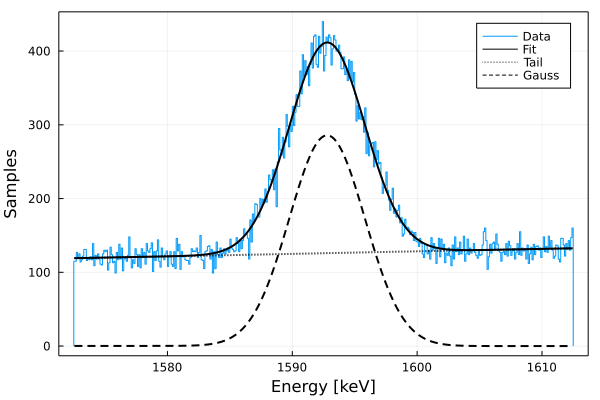

In [1374]:
index = eachindex(AoE)#findall(x-> x < high_cut, AoE)
h = fit(Histogram, E[index], rng)

p0_dict = calib[ctn[ch]][set]["fits"]["peaks_first_cal"]["1592.5"][1]
p0 = (
    n = p0_dict["n"],
    σ = p0_dict["σ"],
    μ = p0_dict["μ"],
    bkg_l = p0_dict["bkg_l"],
    bkg_r = p0_dict["bkg_r"],
    c = 1,#p0_dict["c"],
    d = p0_dict["d"],
    β = p0_dict["β"]
)
prior = NamedTupleDist(
    n = p0.n/5..p0.n*30,
    σ = p0.σ/1.5..p0.σ*1.75,
    μ = p0.µ - 2..p0.µ + 2,
    bkg_l = 0.1..p0.bkg_l*30,
    bkg_r = 0.1..p0.bkg_r*30,
    c = 0.1..2.0,
    d = 0.1..25.0,
    β = p0_dict["β"]/2..10.0
)


samples = try bat_fit(h, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
catch
    IJulia.clear_output(true)
    try bat_fit(h, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
    catch
        IJulia.clear_output(true)
        try bat_fit(h, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            nothing
        end
    end
end
IJulia.clear_output(true)
par, err = mode(samples), std(samples);
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
y_tail = peak(x_fit, par_tail)
y_tail ./= sum(y_tail)
y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
y_tail .*= sum(h.weights)

par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = 0, bkg_r = 0, c = 0, d = par.d, β = par.β)
y_gauss = peak(x_fit, par_gauss)
y_gauss ./= sum(y_gauss)
y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
y_gauss .*= sum(h.weights)

# E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
p = plot(h, st=:step, label="Data");
p = plot!(x_fit, y_fit, label="Fit", lw=2, color=:black);
p = plot!(x_fit, y_tail, color=:black, style=:dot, lw=2, label="Tail");
p = plot!(x_fit, y_gauss, color=:black, style=:dash, lw=2, label="Gauss");
p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box)

cut_lib[ctn[ch]][set]["DEP_ref"] = [par, err]
open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end
@bell sleep(1)
p

### Counting Method

In [1375]:
sig_shift = cut_lib[ctn[ch]]["data"]["summing"]["sig_shift"]
sig_num = cut_lib[ctn[ch]]["data"]["summing"]["sig_num"]
sig_shift, sig_num

(2, 3)

In [1377]:
# Manual change
sig_shift, sig_num = 2.5,2.5
sig_shift, sig_num = 2,2
# sig_shift, sig_num = 3,3

(2, 2)

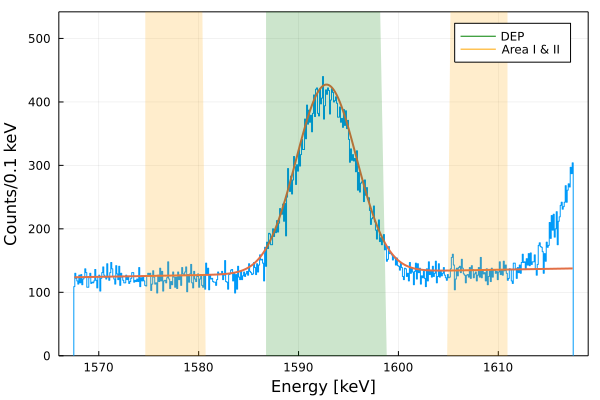

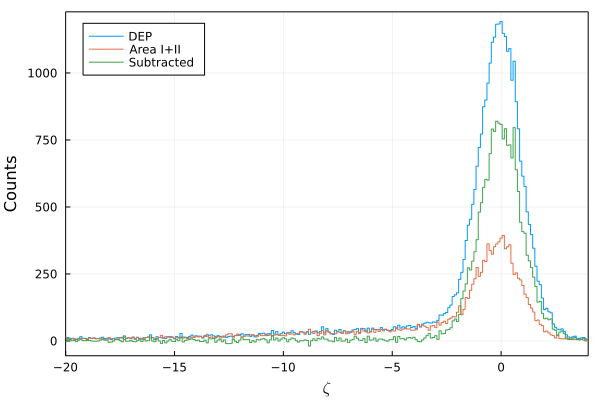

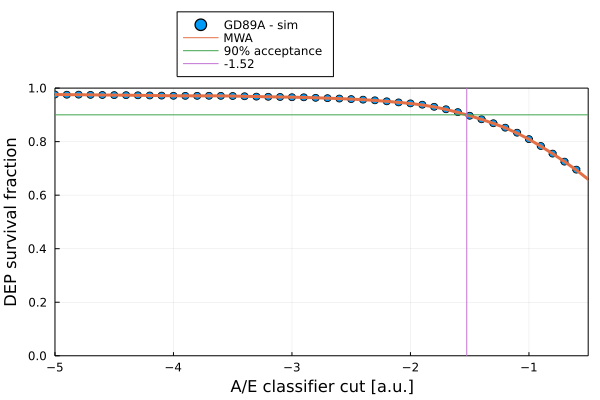

In [1378]:
cut_lib = JSON.parsefile(cut_lib_filepath)
rng_width = 25
rng = 1592.5-rng_width:rng_step:1592.5+rng_width


index = eachindex(AoE)#findall(x-> x < high_cut, AoE)

parNoCut_dict = cut_lib[ctn[ch]][set]["DEP_ref"][1]
parNoCut = (
    n = parNoCut_dict["n"],
    σ = parNoCut_dict["σ"],
    μ = parNoCut_dict["μ"],
    bkg_l = parNoCut_dict["bkg_l"],
    bkg_r = parNoCut_dict["bkg_r"],
    c = parNoCut_dict["c"],
    d = parNoCut_dict["d"],
    β = parNoCut_dict["β"]
)
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

h = fit(Histogram, E[index], rng)

hist_step_size = rng_step

indexDEP = findall(x -> x >= parNoCut.µ - sig_num * parNoCut.σ && x <= parNoCut.µ + sig_num * parNoCut.σ, E[index])
indexBkg = findall(x -> x >= parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ && x < parNoCut.µ - (sig_num + sig_shift) * parNoCut.σ || x <= parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ && x > parNoCut.µ + (sig_num + sig_shift) * parNoCut.σ, E[index])
hDEP = fit(Histogram, E[index][indexDEP], parNoCut.µ - sig_num * parNoCut.σ:hist_step_size:parNoCut.µ + sig_num * parNoCut.σ)
hBkg = fit(Histogram, E[index][indexBkg], parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ:hist_step_size:parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ)
p = plot(h, st=:step, label="")
p = plot!(x_fit, y_fit, label="", lw=2)
# p = plot!(hDEP, st=:step)
# p = plot!(hBkg, st=:step)
p = plot!([parNoCut.µ - sig_num * parNoCut.σ,parNoCut.µ + sig_num * parNoCut.σ], [-2, -2], ribbon=[-10000,1], label="DEP", fillalpha=0.2, color=:green)
p = plot!([parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ,parNoCut.µ - (sig_num + sig_shift) * parNoCut.σ], [-2, -2], ribbon=[-10000,1], label="Area I & II", fillalpha=0.2, color=:orange)
p = plot!([parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ, parNoCut.µ + (sig_num + sig_shift) * parNoCut.σ], [-2, -2], ribbon=[-10000,1], label="", fillalpha=0.2, color=:orange)
p = plot!(xlabel="Energy [keV]", ylabel="Counts/0.1 keV", framestyle=:box, ylim=(0, 100+maximum(hDEP.weights)))
filename = joinpath(plots_path, "counting_areas.pdf")
savefig(p, filename)
display(p)

AE_rng = floor(minimum(AoE[index][indexDEP]), digits=1) - 0.05:0.1:high_cut
AE_DEP = fit(Histogram, AoE[index][indexDEP], AE_rng)
AE_Bkg = fit(Histogram, AoE[index][indexBkg], AE_rng)

hNew = fit(Histogram, AoE[index][indexDEP], AE_rng)
hNew.weights = AE_DEP.weights .- AE_Bkg.weights;

p = plot(AE_DEP, st=:step, label="DEP")
p = plot!(AE_Bkg, st=:step, label="Area I+II")
p = plot!(hNew, st=:step, label="Subtracted")
p = plot!(xlabel=L"\zeta", ylabel="Counts", framestyle=:box, xlim=(-20,4), legend=:topleft)
filename = joinpath(plots_path, "counting_histogram.pdf")
savefig(p, filename)
display(p)


cumulative = []
c = 0
for i in eachindex(hNew.weights)
    c += hNew.weights[i]
    push!(cumulative, c)
end

x = midpoints(hNew.edges[1])
y = 1 .- cumulative ./ sum(hNew.weights)
index_cut = findall(x->x >= -15 && x <= 0, midpoints(hNew.edges[1]))
x = x[index_cut]
y = y[index_cut]
cumulative = cumulative[index_cut]

y_err = []
for i in eachindex(x)
    k = cumulative[i]
    N = sum(hNew.weights)
    err = (1/N) * sqrt(abs(k*(1-k/N)))
    push!(y_err, err)
end

survival_mwa = movingaverage(y, 3)
s = float.(survival_mwa)
itp = interpolate(s, BSpline(Cubic(Line(OnGrid())))) 
sitp = Interpolations.scale(itp, round(minimum(x), digits=3):round(x[2] - x[1], digits=3):round(maximum(x), digits=3));
p = scatter(x, y, yerr=y_err, label=ctn[ch] * " - " * set)
p = plot!(x, survival_mwa, label="MWA", lw=3)
p = hline!([0.9], label="90% acceptance")

if maximum(sitp) > 0.9
    start = findfirst(x -> x < 0.9, s) - 2
    cut_x = x[start]
    while true
        round(sitp[cut_x], digits=5) <= 0.9 ? break : cut_x += 0.0001
    end

    p = vline!([cut_x], label=string(round(cut_x, digits=2)))
end

cut_lib[ctn[ch]][set]["summing"] = Dict()
cut_lib[ctn[ch]][set]["summing"]["sig_shift"] = sig_shift
cut_lib[ctn[ch]][set]["summing"]["sig_num"] = sig_num
cut_lib[ctn[ch]][set]["summing"]["hist_step_size"] = hist_step_size
cut_lib[ctn[ch]][set]["summing"]["cuts"] = x
cut_lib[ctn[ch]][set]["summing"]["sf"] = y
cut_lib[ctn[ch]][set]["summing"]["sf_err"] = y_err
cut_lib[ctn[ch]][set]["summing"]["cut"] = maximum(sitp) > 0.9 ? cut_x : -10


open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end

p = plot!(ylim=(0,1), xlim=(-5,-0.5), xlabel="A/E classifier cut [a.u.]", ylabel="DEP survival fraction", framestyle=:box)
p = plot!(legend=:outertop)
display(p)

# 90% DEP acceptance cut - Fit Method

In [1379]:
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
cut_lib[ctn[ch]][set]

E = deepcopy(data.E)
A = deepcopy(data.A)
# rng_width = 15
# rng = 1592.5-rng_width:rng_step:1592.5+rng_width

AoE = A ./ E
AoE ./= calib[ctn[ch]][set]["AE_norm"]
AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
AoE .-= 1
AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

# rng_step  = 0.1
rng_width = 20
rng = 1592.5-rng_width:rng_step*2:1592.5+rng_width

1572.5:0.2:1612.5

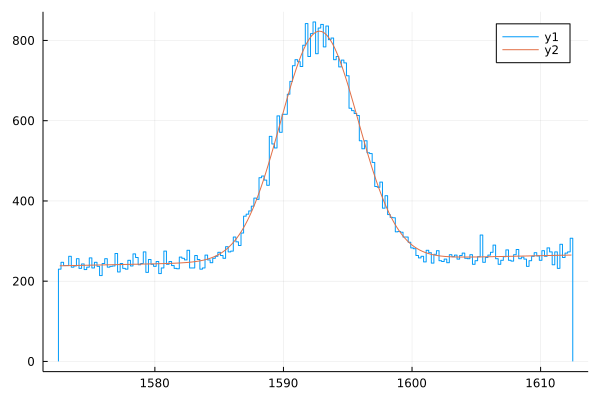

(n = 21638.733687450072, σ = 3.02216511318822, μ = 1592.7899868690042, bkg_l = 1191.7539385593088, bkg_r = 1323.7039309667186, c = 1.6967278177823404, d = 2.1074381079608444, β = 6.517938356442057)

In [1380]:
cut_lib = JSON.parsefile(cut_lib_filepath)

index = eachindex(AoE)#findall(x-> x < high_cut, AoE)
h = fit(Histogram, E[index], rng)

parNoCut_dict = cut_lib[ctn[ch]][set]["DEP_ref"][1]
parNoCut = (
    n = parNoCut_dict["n"],
    σ = parNoCut_dict["σ"],
    μ = parNoCut_dict["μ"],
    bkg_l = parNoCut_dict["bkg_l"],
    bkg_r = parNoCut_dict["bkg_r"],
    c = parNoCut_dict["c"],
    d = parNoCut_dict["d"],
    β = parNoCut_dict["β"]
)
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, parNoCut)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

h = fit(Histogram, E[index], rng)
p = plot(h, st=:step)
p = plot!(x_fit, y_fit)
display(p)
parNoCut

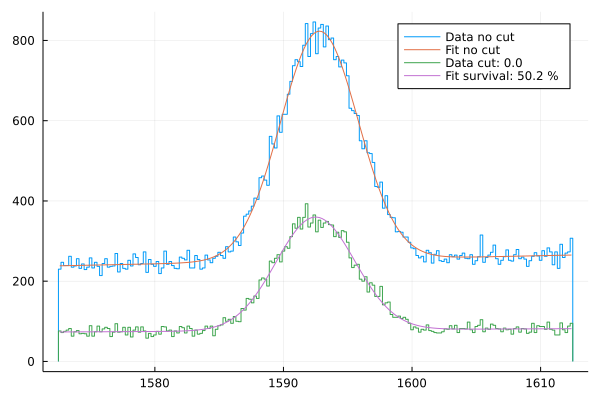

Fitting survival fractions100%|█████████████████████████| Time: 0:01:27


In [1381]:
!haskey(cut_lib[ctn[ch]][set], "fitting") ? cut_lib[ctn[ch]][set]["fitting"] = Dict() : ""
cut_lib[ctn[ch]][set]["fitting"]["fits"] = Dict()
open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end
cuts = (-4):0.1:(0.0)
@showprogress 1 "Fitting survival fractions" for c in eachindex(cuts)
    cut = cuts[c]

    cut_lib = JSON.parsefile(cut_lib_filepath)
    indexCut =  findall(x-> cut < x, AoE)
    
    hCut = fit(Histogram, E[indexCut], rng)
    
    if c == 1
        p0 = deepcopy(parNoCut)
        prior = NamedTupleDist(
            n = p0.n/5..p0.n*1.2,
            σ = p0.σ/1.5..p0.σ*1.5,
            μ = p0.µ - 3..p0.µ + 3,
            bkg_l = 0.1..p0.bkg_l*2,
            bkg_r = 0.1..p0.bkg_r*2,
            c = p0.c/10..p0.c*1.01,
            d = p0.d/10..p0.d*5,
            β = 0.2..p0.β*10
        )
    elseif haskey(cut_lib[ctn[ch]][set]["fitting"]["fits"], string(cuts[c-1]))
        p0_dict = cut_lib[ctn[ch]][set]["fitting"]["fits"][string(cuts[c-1])][1]
        p0 = (
            n = p0_dict["n"],
            σ = p0_dict["σ"],
            μ = p0_dict["μ"],
            bkg_l = p0_dict["bkg_l"],
            bkg_r = p0_dict["bkg_r"],
            c = p0_dict["c"],
            d = p0_dict["d"],
            β = p0_dict["β"]
        )
        prior = NamedTupleDist(
            n = p0.n/1.1..p0.n*1.1,
            σ = p0.σ/1.1..p0.σ*1.1,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = p0.bkg_l/1.1..p0.bkg_l*1.1,
            bkg_r = p0.bkg_r/1.1..p0.bkg_r*1.1,
            c = p0.c/1.1..p0.c*1.01,
            d = p0.d/1.1..p0.d*1.1,
            β = p0.β/1.1..p0.β*1.1
        )
    else
        p0 = deepcopy(parNoCut)
        prior = NamedTupleDist(
            n = p0.n/5..p0.n*1.2,
            σ = p0.σ/1.5..p0.σ*1.5,
            μ = p0.µ - 3..p0.µ + 3,
            bkg_l = 0.1..p0.bkg_l*2,
            bkg_r = 0.1..p0.bkg_r*2,
            c = p0.c/10..p0.c*1.01,
            d = p0.d/10..p0.d*5,
            β = 0.1..p0.β*10
        )
    end
    fail = false
#     display(plot(hCut, st=:step))
#     samples = bat_fit(hCut, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
    samples = try bat_fit(hCut, peak, prior; nsamples=1*10^4, nchains=4, params_first=false, norm_expected=false)
    catch
        IJulia.clear_output(true)
        try bat_fit(hCut, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            IJulia.clear_output(true)
            try bat_fit(hCut, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
            catch 
                fail = true
            end
        end
    end
    
    IJulia.clear_output(true)
    if !fail
        parCut, errCut = mode(samples), std(samples)
        
        k = (parCut[1] + parCut[6])# * calCut
        N = (parNoCut[1] + parNoCut[6]) #* calNoCut
        sf = k/N
        sf_err = (1/N) * sqrt(abs(k*(1-k/N)))
        sf, sf_err

        !haskey(cut_lib[ctn[ch]][set], "fitting") ? cut_lib[ctn[ch]][set]["fitting"] = Dict() : ""
        !haskey(cut_lib[ctn[ch]][set]["fitting"], "fits") ? cut_lib[ctn[ch]][set]["fitting"]["fits"] = Dict() : ""
        cut_lib[ctn[ch]][set]["fitting"]["fits"][string(cut)] = [parCut, errCut, sf, sf_err]
        cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"] = rng_step
        open(cut_lib_filepath, "w") do f
            JSON.print(f, cut_lib, 4)
        end

        x_fit = float.(midpoints(h.edges[1]))
        y_fit = peak(x_fit, parNoCut)
        y_fit ./= sum(y_fit)
        y_fit .*= sum(h.weights)

        h = fit(Histogram, E[index], rng)
        p = plot(h, st=:step, label="Data no cut")
        p = plot!(x_fit, y_fit, label="Fit no cut")

        x_fit = float.(midpoints(hCut.edges[1]))
        y_fit = peak(x_fit, parCut)
        y_fit ./= sum(y_fit)
        y_fit .*= sum(hCut.weights)

        p = plot!(hCut, st=:step, label="Data cut: " * string(cut))
        p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=1)) * " %")
        display(p)
    else
        @info("FAIL for " * string(cuts[c]))
    end
end

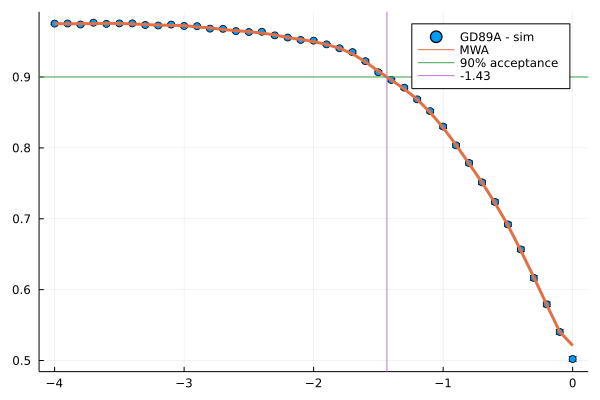

In [1382]:
cut_lib = JSON.parsefile(cut_lib_filepath)
x = []
y = []
y_err = []
for (k,v) in cut_lib[ctn[ch]][set]["fitting"]["fits"]
    if parse(Float64, k) > -5
        push!(x, parse(Float64, k))
        push!(y, v[3])
        push!(y_err, v[4])
    end
end
x_sort = sort(x)
y_sort = []
y_err_sort = []
for x1 in x_sort
    i = findfirst(a-> a == x1, x)
    push!(y_sort, y[i])
    push!(y_err_sort, y_err[i])
end
x = x_sort
y = y_sort
y_err = y_err_sort
survival_mwa = movingaverage(y, 3)
s = float.(survival_mwa)
itp = interpolate(s, BSpline(Cubic(Line(OnGrid())))) 
sitp = Interpolations.scale(itp, round(minimum(x), digits=3):round(x[2] - x[1], digits=3):round(maximum(x), digits=3));
p = scatter(x, y, yerr=y_err, label=ctn[ch] * " - " * set)
p = plot!(x, survival_mwa, label="MWA", lw=3)
p = hline!([0.9], label="90% acceptance")
if maximum(sitp) > 0.9
    start = findfirst(x -> x < 0.9, s) - 2
    cut_x = x[start]
    while true
        round(sitp[cut_x], digits=5) <= 0.9 ? break : cut_x += 0.0001
    end

    p = vline!([cut_x], label=string(round(cut_x, digits=2)))
end
cut_lib[ctn[ch]][set]["fitting"]["cut"] = maximum(sitp) > 0.9 ? cut_x : -10
cut_lib[ctn[ch]][set]["fitting"]["cuts"] = x
cut_lib[ctn[ch]][set]["fitting"]["sf"] = y
cut_lib[ctn[ch]][set]["fitting"]["sf_err"] = y_err
open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end
p

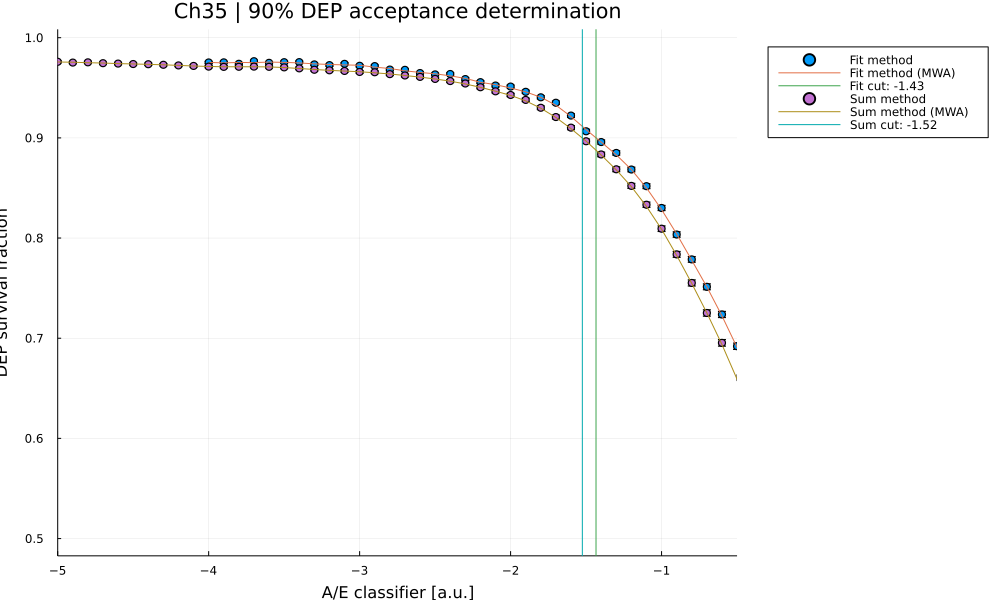

In [1383]:
cut_lib = JSON.parsefile(cut_lib_filepath)
x_fit_cut = cut_lib[ctn[ch]][set]["fitting"]["cut"]
x_fit = cut_lib[ctn[ch]][set]["fitting"]["cuts"]
y_fit = cut_lib[ctn[ch]][set]["fitting"]["sf"]
y_err_fit = cut_lib[ctn[ch]][set]["fitting"]["sf_err"]

x_sum_cut = cut_lib[ctn[ch]][set]["summing"]["cut"]
x_sum = cut_lib[ctn[ch]][set]["summing"]["cuts"]
y_sum = cut_lib[ctn[ch]][set]["summing"]["sf"]
y_err_sum = cut_lib[ctn[ch]][set]["summing"]["sf_err"]

p = plot(xlabel="A/E classifier [a.u.]", ylabel="DEP survival fraction", size=(1000,600), legend=:outertopright, xlim=(-5,-0.5))
p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination")

p = scatter!(x_fit, y_fit, yerr=y_err_fit, label="Fit method")
p = plot!(x_fit, movingaverage(y_fit, 3), label="Fit method (MWA)")
p = vline!([x_fit_cut], label="Fit cut: " * string(round(x_fit_cut, digits=2)))

p = scatter!(x_sum, y_sum, yerr=y_err_sum, label="Sum method")
p = plot!(x_sum, movingaverage(y_sum, 3), label="Sum method (MWA)")
p = vline!([x_sum_cut], label="Sum cut: " * string(round(x_sum_cut, digits=2)))

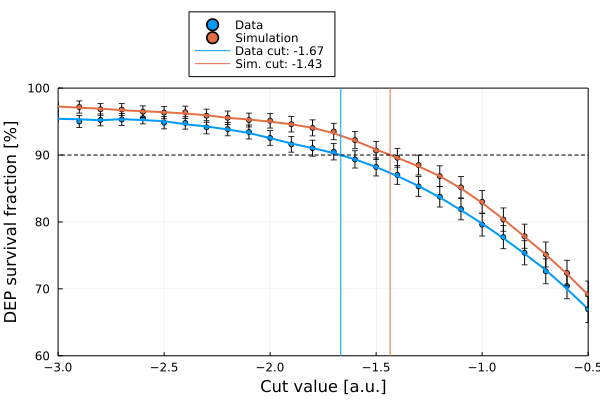

In [1384]:
# ch = 1
ch_str = lpad(ch, 2, "0")

# p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination | Fitting")

cut_lib = JSON.parsefile(cut_lib_filepath)
x_fit_cut = cut_lib[ctn[ch]][set]["fitting"]["cut"]
x_fit = cut_lib[ctn[ch]][set]["fitting"]["cuts"]
y_fit = cut_lib[ctn[ch]][set]["fitting"]["sf"]
y_err_fit = cut_lib[ctn[ch]][set]["fitting"]["sf_err"]

x_fit_sim = deepcopy(x_fit)
y_fit_sim = deepcopy(y_fit)
y_err_sim = deepcopy(y_err_fit)
x_cut_sim = deepcopy(x_fit_cut)

x_fit_cut = cut_lib[ctn[ch]]["data"]["fitting"]["cut"]
x_fit = cut_lib[ctn[ch]]["data"]["fitting"]["cuts"]
y_fit = cut_lib[ctn[ch]]["data"]["fitting"]["sf"]
y_err_fit = cut_lib[ctn[ch]]["data"]["fitting"]["sf_err"]

x_fit_data = deepcopy(x_fit)
y_fit_data = deepcopy(y_fit)
y_err_data = deepcopy(y_err_fit)
x_cut_data = deepcopy(x_fit_cut)


p = plot(xlabel="Cut value [a.u.]", ylabel="DEP survival fraction [%]", legend=:outertop, xlim=(-3,-0.5), ylim=(60,100), framestyle=:box)#, size=(1000,600)
p = scatter!(x_fit_data, y_fit_data.*100, yerr=y_err_data.*100, label="Data", color=dat_col, markersize=3)
p = plot!(x_fit_data, movingaverage(y_fit_data, 3).*100, label="", lw=2, color=dat_col)
p = scatter!(x_fit_sim, y_fit_sim.*100, yerr=y_err_fit.*100, label="Simulation", color=sim_col, markersize=3)
p = plot!(x_fit_sim, movingaverage(y_fit_sim, 3).*100, label="", lw=2, color=sim_col)
p = vline!([x_cut_data], label="Data cut: " * string(round(x_cut_data, digits=2)), color=dat_col)
p = vline!([x_cut_sim], label="Sim. cut: " * string(round(x_cut_sim, digits=2)), color=sim_col)
p = hline!([90], label="", style=:dash, color=:black)

# Comparison all detectors - Cut value

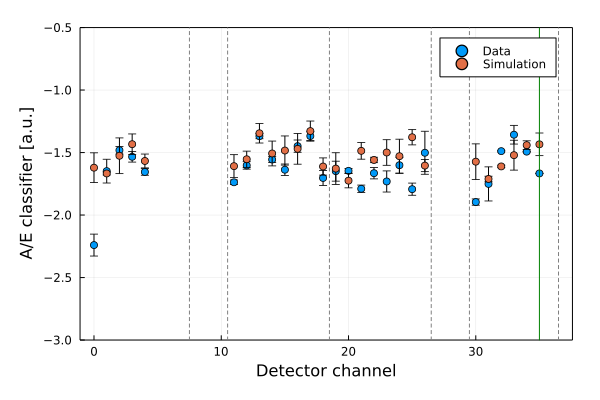

In [1387]:
cuts = Dict(
    "data" => [[], [], []],
    "sim" => [[], [], []]
)
cut_lib = JSON.parsefile(cut_lib_filepath)

for ch in 0:1:36
    if ctb[ch] && !(ch in [5,6,7])
        ch_str = lpad(ch, 2, "0")
#         ds = det_lib[ctn[ch]]["ds"]
        if haskey(cut_lib[ctn[ch]], "data")
            if haskey(cut_lib[ctn[ch]]["data"], "fitting")
                if haskey(cut_lib[ctn[ch]]["data"]["fitting"], "cut")
                    push!(cuts["data"][1], ch)
                    push!(cuts["data"][2], cut_lib[ctn[ch]]["data"]["fitting"]["cut"])
                    push!(cuts["data"][3], abs(cut_lib[ctn[ch]]["data"]["summing"]["cut"] - cut_lib[ctn[ch]]["data"]["fitting"]["cut"]))
                end
            end
        end
        if haskey(cut_lib[ctn[ch]], "sim")
            if haskey(cut_lib[ctn[ch]]["sim"], "fitting")
                if haskey(cut_lib[ctn[ch]]["sim"]["fitting"], "cut")
                    push!(cuts["sim"][1], ch)
                    push!(cuts["sim"][2], cut_lib[ctn[ch]]["sim"]["fitting"]["cut"])
                    push!(cuts["sim"][3], abs(cut_lib[ctn[ch]]["sim"]["summing"]["cut"] - cut_lib[ctn[ch]]["sim"]["fitting"]["cut"]))
                end
            end
        end
    end
end
ch_str = lpad(ch, 2, "0")
scatter(cuts["data"][1], cuts["data"][2], yerr = cuts["data"][3], label="Data")
scatter!(cuts["sim"][1], cuts["sim"][2], yerr = cuts["sim"][3], label="Simulation")
plot!(xlabel="Detector channel", ylabel="A/E classifier [a.u.]")
# vline!([5,7], label="Invalid/noisy")
vline!([7.5,10.5,18.5,26.5,29.5,36.5], label="", style=:dash, color=:gray)
plot!(format=:svg, framestyle =:box, margin=5Plots.mm, ylim=(-3,-0.5))
vline!([ch], label="", color=:green)
# savefig("status.pdf")

In [1386]:
@bell sleep(1)

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5